In [5]:
import pandas as pd
import mojimoji
import MeCab
import requests
import re
from nltk.corpus import stopwords
import nltk
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim import corpora, matutils
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
from sklearn.svm import OneClassSVM

In [241]:
df["hatena_bookmark_count"].values.shape

(77176,)

In [345]:
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

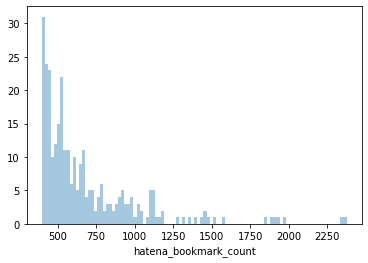

In [266]:
sns.distplot(df[df["hatena_bookmark_count"] >= 400]["hatena_bookmark_count"], kde=False, rug=False, bins=100)


In [6]:
df = pd.read_csv("/Users/kishimoto/go/src/github.com/kishimoto-banana/velvet-crawler/crawled_hatena.csv")

In [8]:
len(df)

77176

In [8]:
len(df[df["hatena_bookmark_count"] == 0])


49129

In [9]:
len(df[df["hatena_bookmark_count"] != 0])

28047

In [196]:
df[df["hatena_bookmark_count"] != 0]["hatena_bookmark_count"].describe()

count    28047.000000
mean        20.641887
std         85.018941
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       2376.000000
Name: hatena_bookmark_count, dtype: float64

In [270]:
df[df["hatena_bookmark_count"] != 0]["hatena_bookmark_count"].quantile(q=[0.75, 0.95])

0.75     9.0
0.95    74.0
Name: hatena_bookmark_count, dtype: float64

In [257]:
df['kouseihi'] = df["hatena_bookmark_count"]/ df["hatena_bookmark_count"].sum()
df['ruiseki'] = df["hatena_bookmark_count"].cumsum() / df["hatena_bookmark_count"].sum()

In [258]:
df.head()

,id,domain,url,title,main_text,published_at,hatena_bookmark_count,created_at,updated_at,kouseihi,ruiseki
0,1,mrtry.hatenablog.jp,https://mrtry.hatenablog.jp/entry/2018/07/08/1...,はてブしたらSlackに通知するGASを書いた - お気持ちの表明,[はてブ](http://d.hatena.ne.jp/keyword/%A4%CF%A4%...,2018-07-08 07:30:04,5,2019-12-31 15:53:58.754482,2019-12-31 15:53:58.754482,0.000009,0.000009
1,2,akasofa.hatenablog.com,http://akasofa.hatenablog.com/entry/2019/12/29...,個人的に選ぶツイートオブザイヤー2019（上半期） - 光景ワレズANNEX,毎年勝手に選んで何の栄誉も無いやつです。自分が読み返して楽しむためのものをシェア〜しているイ...,2019-12-29 02:36:26,1,2019-12-31 15:54:30.481937,2019-12-31 15:54:30.481937,0.000002,0.000010
2,3,notargs.hateblo.jp,https://notargs.hateblo.jp/entry/sponge,【Unity】サクッとメンガーのスポンジを作図する - のたぐすブログ,"Cluster,Inc. Advent Calendar 2018、25日目の記事です。\n...",2018-12-24 15:00:00,0,2019-12-31 15:54:30.74233,2019-12-31 15:54:30.74233,0.000000,0.000010
3,4,mrtry.hatenablog.jp,https://mrtry.hatenablog.jp/entry/2018/08/12/1...,鴨居フックとワイヤーネットでケーブルトレーもどきを実装する - お気持ちの表明,机周りを整理しているとき、配線をきれいにしたいなと思いました。\n\nケー[ブルトレ](ht...,2018-08-12 08:39:16,0,2019-12-31 15:54:33.479734,2019-12-31 15:54:33.479734,0.000000,0.000010
4,5,mrtry.hatenablog.jp,https://mrtry.hatenablog.jp/entry/2018/11/15/2...,React NativeとExpoの話題でDroidKaigiに登壇することになりました -...,## 登壇することになりました\n\nあばばばば。\n\n前職で生React Nativeで...,2018-11-15 12:05:23,3,2019-12-31 15:54:33.609174,2019-12-31 15:54:33.609174,0.000005,0.000016


In [9]:
stopword_url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
response = requests.get(stopword_url)
ja_stopwords = [w for w in response.content.decode().split('\r\n') if w != '']
en_stopwords = stopwords.words("english")
my_stopwords =  ["の", ".com", "images", "id", "hatena", "ん", "fotolife", ".jpg", "plain", "image", "png", "さ", "at", "%", "n/", "www", "ら", ".s", "()"]
stopwords = ja_stopwords + en_stopwords + my_stopwords

target_parts_of_speech = ('名詞')
regex = re.compile(r'\d')

In [10]:

def tokenize(sentence, dict_path=None):
    sentence = re.sub(r'r://[\w/:%#\$&\?~\.=\+\-]+', '', sentence)
    if dict_path is not None:
        tagger = MeCab.Tagger(f'-d {dict_path}')
    else:
        tagger = MeCab.Tagger()
        
    tokenized_sentence = []
    regex = re.compile(r'\d')
    regax_one = re.compile(r"^\w$")
    try:
        for chunk in tagger.parse(sentence).splitlines()[:-1]:
            (surface, feature) = chunk.split('\t')
            if feature.startswith(target_parts_of_speech):
                if surface not in stopwords:
                    if not regex.search(surface) and not regax_one.search(surface):
                        word = word_normiraze(surface)
                        tokenized_sentence.append(word)
    except Exception:
        print("err")
        print(sentence)
                    
    return tokenized_sentence

def word_normiraze(word):
    """単語の正規化
    """
    word = word.lower()
    word = mojimoji.han_to_zen(word, ascii=False, digit=False)
    word = mojimoji.zen_to_han(word, kana=False)

    return word

In [1]:
dict_path = "/usr/local/lib/mecab/dic/mecab-ipadic-neologd/"

tokenized_sentences = []
for idx, main_text in enumerate(df["main_text"].values):
    if idx % 1000 == 0:
        print(idx, len(tokenized_sentences))
    tokenized_sentences.append(tokenize(main_text, dict_path))

In [12]:
corpus = [' '.join(d) for d in tokenized_sentences]

In [50]:
vec = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b', min_df=0.00007142857, max_df=0.7)
# vec = TfidfVectorizer(token_pattern=u'(?u)\\b\\w+\\b', min_df=0.00007142857, max_df=0.7)
X_bow = vec.fit_transform(corpus)

In [44]:
joblib.dump(vec, "vectorizer.pkl")

['vectorizer.pkl']

In [16]:
count_char = lambda x: len(x)
char_counts = df["main_text"].map(count_char).values

In [17]:
word_counts = np.array([len(sentence) for sentence in tokenized_sentences])

In [45]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_bow)

In [46]:
joblib.dump(svd, "svd.pkl")

['svd.pkl']

In [64]:
X = np.hstack([X_svd, char_counts.reshape(char_counts.shape[0], -1), word_counts.reshape(word_counts.shape[0], -1)])

In [63]:
y = ((df["hatena_bookmark_count"] != 0) * 1).values

In [65]:
sampler = RandomUnderSampler(sampling_strategy={0: y.sum(), 1: y.sum()}, random_state=42)
X_sampled, y_sampled = sampler.fit_sample(X_svd, y)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled,
                                                    y_sampled,
                                                    test_size=0.3,
                                                    random_state=0)

In [69]:
pred = model.predict(X_test)

In [70]:
pred

array([0., 1., 1., ..., 0., 1., 0.])

In [67]:
# 分類
model = CatBoostClassifier(num_boost_round=100,
                           loss_function='Logloss',
#                            early_stopping_rounds=10,
                           )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# model.fit(X_train, y_train)
# 確率がほしいときは predict_proba() を使う
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Learning rate set to 0.307342
0:	learn: 0.6242926	test: 0.6223016	best: 0.6223016 (0)	total: 48.1ms	remaining: 4.76s
1:	learn: 0.5908227	test: 0.5873155	best: 0.5873155 (1)	total: 71.8ms	remaining: 3.52s
2:	learn: 0.5650298	test: 0.5603706	best: 0.5603706 (2)	total: 95.5ms	remaining: 3.09s
3:	learn: 0.5528708	test: 0.5480307	best: 0.5480307 (3)	total: 120ms	remaining: 2.88s
4:	learn: 0.5448099	test: 0.5410246	best: 0.5410246 (4)	total: 143ms	remaining: 2.72s
5:	learn: 0.5391795	test: 0.5359746	best: 0.5359746 (5)	total: 165ms	remaining: 2.58s
6:	learn: 0.5350987	test: 0.5324162	best: 0.5324162 (6)	total: 193ms	remaining: 2.56s
7:	learn: 0.5310696	test: 0.5290756	best: 0.5290756 (7)	total: 234ms	remaining: 2.69s
8:	learn: 0.5267870	test: 0.5253570	best: 0.5253570 (8)	total: 263ms	remaining: 2.65s
9:	learn: 0.5244563	test: 0.5233710	best: 0.5233710 (9)	total: 283ms	remaining: 2.55s
10:	learn: 0.5212415	test: 0.5206804	best: 0.5206804 (10)	total: 305ms	remaining: 2.47s
11:	learn: 0.518812

In [68]:
joblib.dump(model, "classifier.pkl")

['classifier.pkl']

In [21]:
# 回帰
# y_reg = (df[df["hatena_bookmark_count"] <= 74]["hatena_bookmark_count"]).values
y_reg = df.query("hatena_bookmark_count != 0 and hatena_bookmark_count < 100")["hatena_bookmark_count"].values

In [326]:
sum((df["hatena_bookmark_count"] < 100) & (df["hatena_bookmark_count"] != 0))

26896

In [22]:
X_reg = X_svd[(df["hatena_bookmark_count"] < 100) & (df["hatena_bookmark_count"] != 0)]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_reg,
                                                    y_reg,
                                                    test_size=0.3,
                                                    random_state=0)

In [38]:
pred = model.predict(X_train)

In [2]:
# 回帰
model = CatBoostRegressor(num_boost_round=500,
                           loss_function='RMSE',
#                            early_stopping_rounds=10,
                           )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# model.fit(X_train, y_train)
# 確率がほしいときは predict_proba() を使う
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('RMSE:', math.sqrt(mse))

In [43]:
import joblib
joblib.dump(model, "regression.pkl")

['regression.pkl']

In [3]:
# 分類
model = CatBoostClassifier(num_boost_round=100,
                           loss_function='Logloss',
#                            early_stopping_rounds=10,
                           )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# model.fit(X_train, y_train)
# 確率がほしいときは predict_proba() を使う
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

In [13]:
import collections
import itertools
vocab = collections.Counter(list(itertools.chain.from_iterable(tokenized_sentences)))